This is a jupyter notebook to get the graphs from geo maps.

In [39]:
import random
import os
import numpy as np
import networkx as nx
import geopandas as gpd
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection


# Load the box module from shapely to create box objects
from shapely.geometry import box, Point, Polygon, MultiPoint, shape, LineString
from shapely.ops import triangulate
from shapely.affinity import translate

from earthpy import clip as cl
import pickle #to save the resulting graphs

# to display images inline
get_ipython().magic(u'matplotlib inline')
matplotlib.use('Agg')# not sure what I used it for
%matplotlib inline 

# RELATIVE NEIGHBORHOOD GRAPH

This notebook demonstrated how Delaunay graphs can be calculated from  OSM data in the form of shapefiles.
Recent OSM data can be downloded from the project website, here we use a French region called Lorraine.

#### Pre-processing:

We processed data in QGIS to merge the buildings which touch, and to extract  certain separate categories from the buildings.

#### Categories
A pre-selected set of objects  is defined. The nodes of our graphs are formed by these objects,each category is cooded as a unique integer. Some of categories are missing from OSM data, but we keep the codes to be consistent.

aerodroms:    0

houses:       1

public build: 2 

railway stat: 3           

sport build:  4

arcs, towers: 5

churches:     6

castles:      7

forts:        8

monuments:    9

cemetries:   10

sport build: 11

roads:       12

water:       13

railroads:   14
 


In [2]:
# define the region folder - folder where OSM data are unpacked
global_path = "./lorraine"

Load all shapefiles as geopandas dataframes. We also convert the data to Lambert 93 on the way.



## ROADS

In [3]:
# load all the shapely files related to ROADS
fp_road = global_path + "/gis_osm_roads_free_1.shp"
all_roads = gpd.read_file(fp_road)
all_roads = all_roads.to_crs("EPSG:2154") 

In [4]:
all_roads.head() # small demo of the roads and the info we have

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,2284506,5131,motorway_link,None,A 31,F,70,0,F,F,"LINESTRING (926317.999 6848103.926, 926303.576..."
1,2306356,5131,motorway_link,None,A 31,F,110,0,F,F,"LINESTRING (925999.230 6847969.946, 926002.566..."
2,2371422,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (911516.762 6818357.130, 911510.086..."
3,2371423,5141,service,None,None,F,0,0,F,F,"LINESTRING (911470.001 6818072.927, 911471.198..."
4,2371424,5141,service,None,None,F,0,0,F,F,"LINESTRING (911445.587 6817975.063, 911440.070..."


## Houses

In [5]:
# Load all the data from the BUILDINGS caegory
fp_bati = global_path + "/buildings_merged.shp"
# Read file using gpd.read_file()
all_buildings = gpd.read_file(fp_bati)
all_buildings = all_buildings.to_crs("EPSG:2154") 


## Churches

In [6]:
#places of worship
churches = global_path +  "/gis_osm_pofw_free_1.shp"
churches = gpd.read_file(churches)
churches=churches.to_crs("EPSG:2154") 

## Towers, castles, forts, monuments

In [7]:
fp_poi = global_path + "/gis_osm_pois_free_1.shp" 
# Read file using gpd.read_file()
poi = gpd.read_file(fp_poi)
poi=poi.to_crs("EPSG:2154") 
poi.fclass.unique()
towers = poi.loc[poi['fclass'] == 'tower']
castels = poi.loc[poi['fclass'] == 'castle']
forts = poi.loc[poi['fclass']=='fort']
monuments = poi.loc[poi['fclass']=='monument']

In [8]:
print("statisics over all POI objects. There %d churches, %d towers, %d monuments, %d forts, %d castles and %d ordinary buildings" 
      %(len(churches),len(towers),len(monuments), len(forts), len(castels), len(all_buildings)))

statisics over all POI objects. There 308 churches, 58 towers, 129 monuments, 5 forts, 88 castles and 880615 ordinary buildings


## WATER 

In [9]:
fp_water =  global_path + "/gis_osm_waterways_free_1.shp"
all_water = gpd.read_file(fp_water)
all_water = all_water.to_crs("EPSG:2154")

## SPORT TERRITORIES

In [10]:
fp_sport = global_path +  "/gis_osm_pois_free_1.shp"
data_sport = gpd.read_file(fp_sport)
data_sport=data_sport.to_crs("EPSG:2154") 
data_sport = data_sport.loc[data_sport['fclass'] == 'stadium']

## CEMETRIES

In [11]:
fp_cemetries = global_path +  "/gis_osm_pois_a_free_1.shp"
data_cemetries = gpd.read_file(fp_cemetries)
data_cemetries=data_cemetries.to_crs("EPSG:2154") 
#pick the graveyards
data_cemetries =  data_cemetries.loc[data_cemetries['fclass'] =='graveyard']

## RAILROADS

In [12]:
#railroads
fp_rail = global_path + "/gis_osm_railways_free_1.shp"
data_rail  = gpd.read_file(fp_rail)
data_rail = data_rail.to_crs("EPSG:2154") 

In [14]:
print("statisics over all line objects. There %d road segments, %d water segements, %d railroad segments" 
      %(len(all_roads),len(all_water),len(data_rail)))

statisics over all line objects. There 305429 road segments, 17094 water segements, 9002 railroad segments


## BOUNDING BOXES FROM THE IMAGES
We use the pre-save bounding boxes, just change the paths to the right one. The bounding box just limits the zone to create different graphs.

In [15]:
image_polygons = gpd.read_file('image_polygons_57.shp') # image polygons for POI in Moselle region

In [16]:
image_polygons

,ID,PREC_PLANI,PREC_ALTI,ORIGIN_BAT,NATURE,HAUTEUR,Z_MIN,Z_MAX,geo_ID,geometry
0,BATIMENT0000000060102862,1.5,1.0,Autre,Aérogare,6,212.1,214.4,1,"POLYGON ((972345.452 6858811.904, 972345.452 6..."
1,BATIMENT0000000060102861,1.5,1.0,Autre,Aérogare,5,213.0,213.9,1,"POLYGON ((972380.718 6858855.627, 972380.718 6..."
2,BATIMENT0000000060048570,1.5,1.0,Autre,Gare,10,311.2,315.0,2,"POLYGON ((1023728.587 6892193.197, 1023728.587..."
3,BATIMENT0000000060048971,1.5,1.0,Autre,Gare,8,344.3,347.0,3,"POLYGON ((1014066.432 6891734.094, 1014066.432..."
4,BATIMENT0000000060057787,1.5,1.0,Autre,Gare,3,258.0,258.9,4,"POLYGON ((1028204.314 6889063.727, 1028204.314..."
...,...,...,...,...,...,...,...,...,...,...
3163,BATIMENT0000000113486870,10.0,9999.0,Autre,"Fort, blockhaus, casemate",0,-99.0,-99.0,3163,"POLYGON ((928535.107 6880714.766, 928535.107 6..."
3164,BATIMENT0000000113487410,10.0,9999.0,Autre,"Fort, blockhaus, casemate",0,-99.0,-99.0,3164,"POLYGON ((934534.633 6895005.422, 934534.633 6..."
3165,BATIMENT0000000113487129,10.0,9999.0,Autre,"Fort, blockhaus, casemate",0,-99.0,-99.0,3165,"POLYGON ((929217.050 6891944.434, 929217.050 6..."
3166,BATIMENT0000000113487021,10.0,9999.0,Autre,"Fort, blockhaus, casemate",0,-99.0,-99.0,3166,"POLYGON ((930223.890 6891458.404, 930223.890 6..."


## Graph creation
Below are the functions defined for each step of Delaunay graph creation procedure.

In [17]:
# parameters of the nodes
def calculate_eccentricity(geometry):
    ''' function calculates eccentricity measure (w/l of min envelop rectangle) '''
    envelop_rect = geometry.minimum_rotated_rectangle
    minx, miny, maxx, maxy = envelop_rect.bounds
    width = maxx - minx
    height = maxy - miny
    if height ==0 or width ==0:
        return 0
    if width < height:
        return  width/height
    else:
        return height/width
        
def calculate_perimeter(geometry):
    ''' function calculates the perimeter of the shapely geometry '''
    return geometry.length
# unit tests
# calculate_perimeter(buildings3.geometry[1])

In [18]:
def get_node_attributes(shapely_geometry, poly_bound, nature, within_poly = True):
    """ function returns attributes of road/house node:
    nature, normed_lenght and eccentricity """
    attributes = {}
    obj_type = nature
    if within_poly:
        obj_length = calculate_perimeter(shapely_geometry)
        frame_perimeter = poly_bound.length
        obj_normed_length = obj_length/frame_perimeter 
        obj_points = calculate_eccentricity(shapely_geometry)
    else:
        obj_normed_length = 0
        obj_points = 0
    attributes = {'nature': obj_type, 'normed_length':obj_normed_length, 
                 'eccentricity':obj_points}
    return attributes

In [19]:
def calculate_distance(obj1, obj2):
    ''' this fucntion calculates the minimum distance between the objects:
    if an object is a polygon, its center is considered as a central point
    if an object is a line, the distance is the lenght of the normal from another object,
    if both objects are lines, the distance is 0'''
    d = None
    if obj1.type == 'Polygon' and obj2.type == 'Polygon':
        #print("polyg polyg")
        proj_dist = obj1.centroid.distance(obj2.centroid) #euclidean distance
        d = proj_dist
    elif obj1.type == 'LineString' and obj2.type == 'Polygon':
        #print("linestr polyg")
        proj_dist= obj2.centroid.distance(obj1) 
#         print(proj_dist)
#         print(obj1.project(obj2.centroid))
        d = proj_dist
    elif obj2.type=='LineString' and obj1.type == 'Polygon':
        #print(" polyg linestr")
        proj_dist= obj1.centroid.distance(obj2)     
        d = proj_dist
    elif obj1.type == 'LineString' and  obj2.type=='LineString':
        #print(" linestr linestr")
        if obj1.intersects( obj2):
            d = 0
        else:
            d = None
    elif obj1.type == 'shapely.geometry.LineString' and  obj2.type=='shapely.geometry.LineString':
        #print(" linestr linestr")
        if obj1.intersects( obj2):
            d = 0
        else:
            d = None    
    else:
        print(" unkn unkn")
        try:
            print(type(obj1),type(obj2))
            d = obj2.distance(obj1.centroid)
        except:
            print('Distance calc didnt work')
            d = None
    #print(f"d is {d} for objects {type(obj1)} {type(obj2)}")
    return d

In [20]:
def determine_if_connected(geodf, idx1, idx2, delaunay_tringales):
    ' check if the nodes are connected in the graph (the centroinds should belong to one triangle):'
    connected = False
    for d_cell in delaunay_tringales:
        if d_cell.intersects(geodf.centroid[idx1]) and d_cell.intersects(geodf.centroid[idx2]): #if they belong to one cell, they are connected
            return True
        
    return connected
        

In [21]:
def calculate_centroids(geodf):
    geodf = geodf.assign(centroid="")
    
    for i in range(len(geodf)):
        if type(geodf.loc[i, ('geometry')]) == 'Point':
            geodf.loc[i, ('centroid')] = geodf.loc[i, ('geometry')]
        else:
            geodf.centroid[i] = geodf.loc[i, ('geometry')].centroid
    
    return geodf

In [22]:
def create_graph_where_object_is_node(gp_frame, poly = None, threshold = 100):
    ''' function takes the pandas frame and creates the graph, where the nodes are rivers and roads,
    and buildings, and sportive objects etc.
    Nodes have the following attributes: 
    a) type of object (road/water/house/church etc)
    b) num of angles / points in the shape geometry
    c) length (divided by HxW of the polygon to scale)
    Edges have no attributes:
    they are calculated by delaunay triangulation
    '''
    pos = {} #dictionary for node coord
    net = nx.Graph() # empty graph   
    attr = {}
    triangles = triangulate(MultiPoint(gp_frame.centroid.tolist()))
    for shp1 in range(0, len(gp_frame)-1): # for each object
        # the geometry property here may be specific to my shapefile
        object1 = gp_frame['geometry'].iloc[shp1] #get the line
        pos[shp1] = [gp_frame['geometry'].iloc[shp1].centroid.x,  gp_frame['geometry'].iloc[shp1].centroid.y]
        # get all line attributes
        attributes = get_node_attributes(object1, poly, gp_frame['nature'].iloc[shp1],gp_frame['withinPoly'].iloc[shp1])
        net.add_node(shp1) # add node
        attr[shp1]= attributes # nested dict
        for shp2 in range(shp1+1, len(gp_frame)):
            object2 = gp_frame['geometry'].iloc[shp2] #get the second object
            connected = determine_if_connected(gp_frame, shp1, shp2, triangles)
            if connected: # if intersects               
                net.add_edge(shp1, shp2) # edge with an attribute

        # add the last element - coz first loop is not for all values, and last node needs attributes
        attributes = get_node_attributes(object2, poly, gp_frame['nature'].iloc[shp2],gp_frame['withinPoly'].iloc[shp2])
        attr[len(gp_frame)-1]= attributes # nested dict
        net.add_node(shp2) # add node 
        nx.set_node_attributes(net, attr)

        pos[shp2] = [gp_frame['geometry'].iloc[shp2].centroid.x, gp_frame['geometry'].iloc[shp2].centroid.y]

    return net, pos

In [23]:
def clean_and_append(final_data, data_segment, nature, polygon_bbox):
    ''' function copies data from a data frame to a new data list of a following structure:
    nature
    within the image (bool) if the object is entirely inside the polygon or not
    geometry
    returns list of lists with objects like  [[nat, within, geom], [], []...]  '''
    # if it is line object
    if data_segment.empty == True:
        pass     
    else:
        # check if object is completely within the polygon
        for index, row in data_segment.iterrows(): # for each element           
            if row['geometry'].geom_type == 'MultiPolygon' or row['geometry'].geom_type == 'MultiLineString':
                for single_obj in row['geometry']:
                        #print("data ", len(final_data), 'obj', type(single_obj))
                        final_data.append([nature, 1, single_obj]) 
                print('a multistring detected and transformed') 
            elif row['geometry'].is_empty or row['geometry']==[]:
                pass
            else:   
                final_data.append([nature, 1, row['geometry']]) # polygons are classified depending on their status always within 

    return final_data

In [24]:
def clip_data(pd_obj, pd_polyg):
    try:
        sg = cl.clip_shp(pd_obj, pd_polyg) #all_roads[all_roads.geometry.intersects(polygon_bbox)] #extract segments of roads
    except:
        sg = pd.DataFrame()
    return sg
    

In [30]:
name = './delaunay_graphs/' 
for i in range (1,2): # len(image_polygons) 
    # randomly shift the polygon box
    polygon_bbox = image_polygons.iloc[i-1:i]
    # randomly shift the polygon box
    randomshift_val = random.randrange(-20, +20)
    #print(polygon_bbox)
    polygon_bbox.geometry = [translate(polygon_bbox.geometry.item(), randomshift_val, randomshift_val)]
    #print(polygon_bbox)
    data = []
    # lines

    sg_roads = clip_data(all_roads, polygon_bbox)  #all_roads[all_roads.geometry.intersects(polygon_bbox)] #extract segments of roads
    data = clean_and_append(data, sg_roads, 12, polygon_bbox)
    sg_water = clip_data(all_water, polygon_bbox)#all_water[all_water.geometry.intersects(polygon_bbox)] #extract segments of water
    data = clean_and_append(data, sg_water, 13, polygon_bbox)
    sg_data_rail = clip_data(data_rail, polygon_bbox)#data_rail[data_rail.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_rail, 14, polygon_bbox)
    # objects
    sg_houses = clip_data(all_buildings, polygon_bbox) #all_buildings[all_buildings.geometry.intersects(polygon_bbox)] #extract segments of buildings
    data = clean_and_append(data, sg_houses, 1, polygon_bbox)
    sg_sport_buil = clip_data(data_sport, polygon_bbox)#sport_buldings[sport_buldings.geometry.intersects(polygon_bbox) ]
    data = clean_and_append(data, sg_sport_buil, 4, polygon_bbox)
    sg_towers = clip_data(towers, polygon_bbox)#towers[towers.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_towers, 5, polygon_bbox)
    sg_churches = clip_data(churches, polygon_bbox) # churches[churches.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_churches, 6, polygon_bbox)
    sg_castels = clip_data(castels, polygon_bbox)#castels[castels.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_castels, 7, polygon_bbox)
    sg_forts = clip_data(forts, polygon_bbox)#forts[forts.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_forts, 8, polygon_bbox)
    sg_monuments = clip_data(monuments, polygon_bbox)#monuments[monuments.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_monuments, 9, polygon_bbox)
    sg_data_cemetries = clip_data(data_cemetries, polygon_bbox)#data_cemetries[data_cemetries.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_cemetries, 10, polygon_bbox)
    sg_sport = clip_data(data_sport, polygon_bbox)#data_sport[data_sport.geometry.intersects(polygon_bbox)] #extract segments of sport  things
    data = clean_and_append(data, sg_sport, 11, polygon_bbox)
    combined_pd = pd.DataFrame(data, columns = ['nature','withinPoly', 'geometry']) 
    sg_houses_rem =  pd.concat([sg_sport_buil,sg_towers,sg_churches,sg_castels,sg_forts,sg_monuments],ignore_index=True)
    combined_pd = calculate_centroids(combined_pd)
    print(name +'graph_main'+ str(i).zfill(5) +'.pickle')
    if combined_pd.empty:
        G = nx.empty_graph()
    else:
        G, pos = create_graph_where_object_is_node(gp_frame=combined_pd, poly=polygon_bbox,  threshold = 35)
    nx.write_gpickle(G, name + str(i).zfill(5) +'_graph' +'.pickle', protocol=4)
    with open(name + str(i).zfill(5)  +'_position.pickle', 'wb') as handle:
        pickle.dump(pos, handle)

C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\geopandas\geodataframe.py:183: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[geo_column_name] = level


./delaunay_graphs/graph_main00001.pickle


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Resulting graphs demo

In [31]:
combined_pd

,nature,withinPoly,geometry,centroid
0,12,1,LINESTRING (972374.9738118855 6858925.28828167...,POINT (972456.3044115457 6858873.084865522)
1,12,1,LINESTRING (972352.4521451127 6858932.52116240...,POINT (972363.712978499 6858928.904722041)
2,13,1,LINESTRING (972455.5912552539 6858818.90417696...,POINT (972410.3778393682 6858873.920127563)
3,1,1,"POLYGON ((972450.2620490968 6858940.602963938,...",POINT (972472.8011388897 6858954.405426401)


In [32]:
sg_roads = sg_roads [~sg_roads.is_empty]   #sometimes, we get empty geometries which should be cleaned
sg_houses = sg_houses [~sg_houses.is_empty]  
sg_water = sg_water [~sg_water.is_empty] 

C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  


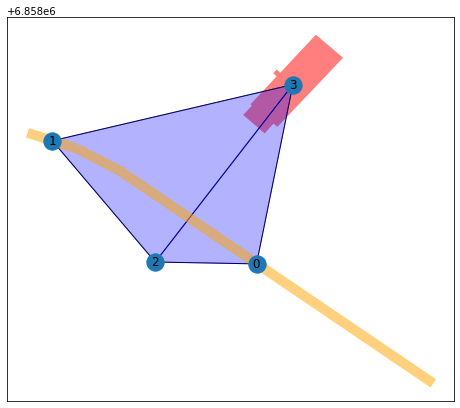

In [40]:
from matplotlib.patches import Polygon as pltPolygon
triangles = triangulate(MultiPoint(combined_pd.centroid.tolist()))
fig, ax = plt.subplots(figsize=(8, 8))

for p in combined_pd.centroid.tolist():
    ax.scatter(p.x,p.y)
for polygon in triangles:
    mpl_poly = pltPolygon(np.array(polygon.exterior),facecolor="b", color = 'b', lw=1, alpha=0.3)
    ax.add_patch(mpl_poly)
sg_roads.plot(linewidth=10.0, edgecolor='#FFA500', color='#FFA500', alpha = 0.5, ax=ax)
sg_houses.plot(color='#FF0000', alpha = 0.5, ax=ax)
#sg_water.plot(linewidth=10.0, color='#0000FF', ax=ax)
#sg_data_rail.plot(linewidth=10.0, color='#FF00FF', ax=ax)
#sg_houses_rem.plot(color='#FFFF00', ax=ax)
nx.draw_networkx(G, pos=pos, with_labels = True, ax = ax) 


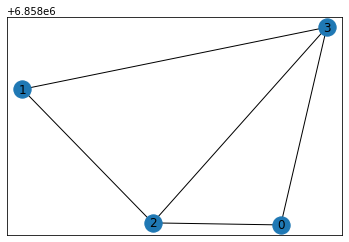

In [41]:
nx.draw_networkx(G, pos=pos, with_labels = True)